## Problem Statement
A liquor store owner is looking to open a new store in the state of Iowa. Given records of Iowa's liquors sales from 2015, I will assess different locations around the state for market potential. The records include number of bottles sold, product details, pricing for transactions at 1,161 stores, as well as store location. From this data, I can investigate the relationship between store location and total volume of sales to advise the store owner which counties are promising locations to build the next store.

I hypothesize that the best location to build a store will be counties with few stores, but high sales, as this indicates a large demand but low competition.

In [26]:
import pandas as pd
import sklearn
from sklearn import linear_model
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

## Load the data into a DataFrame and preview
transactions = pd.read_csv('/Users/teresaborcuch/DSI-course-materials/curriculum/04-lessons/week-03/2.4-lab/Iowa_Liquor_sales_sample_10pct.csv')
transactions.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


### Clean, Refine, and Mine the Data
I'll remove redundant columns, drop rows with incomplete data, and filter to only include stores that were open for all of 2015. Additionally, I'll calculate average price per bottle at each store and profit margin, and count the number of stores in each county

In [27]:
transactions = transactions.drop(['County Number', 'Vendor Number','Item Number','Item Description', 'Volume Sold (Gallons)'], axis = 1)

In [28]:
# Remove $
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    transactions[col] = transactions[col].apply(lambda x: float(x[1:]))

In [29]:
# Drop NA's
transactions = transactions.dropna()

In [30]:
# Convert dates
transactions["Date"] = pd.to_datetime(transactions["Date"], format="%m/%d/%Y")

In [31]:
# Calculate margins, unit prices
transactions["Margin"] = (transactions["State Bottle Retail"] - transactions["State Bottle Cost"]) * transactions["Bottles Sold"]
transactions["Price per Liter"] = transactions["Sale (Dollars)"] / transactions["Volume Sold (Liters)"]
transactions["Price per Bottle"] = transactions["Sale (Dollars)"]/ transactions["Bottles Sold"]

In [32]:
# Sales per store, 2015
# Filter by our start and end dates
transactions.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (transactions['Date'] >= start_date) & (transactions['Date'] <= end_date)
sales = transactions[mask]

# Group by store name
sales = sales.groupby(by="Store Number", as_index=False)
# Compute sums, means
sales = sales.agg({"County": lambda x: x.iloc[0],
                   "Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.sum,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "Bottles Sold": [np.sum, np.mean], 
                  "Price per Bottle": np.mean})
# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]
# Rename columns
sales.columns = [u'store_num', u'county', u'city', u'mean_ppb',u'total_bottles',
                 u'mean_bottles', u'total_sales',u'mean_sales', u'total_liters',
                 u'mean_liters', u'zip_code',u'mean_ppl', u'margin']

cols = ['store_num','zip_code','county','city','total_sales','mean_sales','margin','total_bottles','mean_bottles','mean_ppb','total_liters','mean_liters','mean_ppl']
sales = sales[cols]
sales["store_num"] = sales["store_num"].astype('string')

In [33]:
# Count number of stores per area
sales['stores_per_county'] = sales.groupby('county')['county'].transform('count')
sales['stores_per_city'] = sales.groupby('city')['city'].transform('count')
sales['stores_per_zip'] = sales.groupby('zip_code')['zip_code'].transform('count')
sales.head()

,store_num,zip_code,county,city,total_sales,mean_sales,margin,total_bottles,mean_bottles,mean_ppb,total_liters,mean_liters,mean_ppl,stores_per_county,stores_per_city,stores_per_zip
0,2106,50613,Black Hawk,CEDAR FALLS,146038.70,277.640114,48742.20,10355,19.686312,15.459734,9719.85,18.478802,17.844997,72,17,16
1,2113,50543,Webster,GOWRIE,9310.22,63.334830,3109.04,671,4.564626,16.315646,659.85,4.488776,18.507700,20,2,2
2,2130,50703,Black Hawk,WATERLOO,111583.91,285.380844,37229.32,7418,18.971867,14.740767,6879.37,17.594297,16.817589,72,46,16
3,2152,50469,Cerro Gordo,ROCKWELL,7721.08,54.759433,2587.53,573,4.063830,12.887660,633.37,4.491986,13.020765,20,1,1
4,2178,52172,Allamakee,WAUKON,24324.18,102.633671,8165.70,1928,8.135021,14.558692,1917.12,8.089114,16.053844,6,3,3


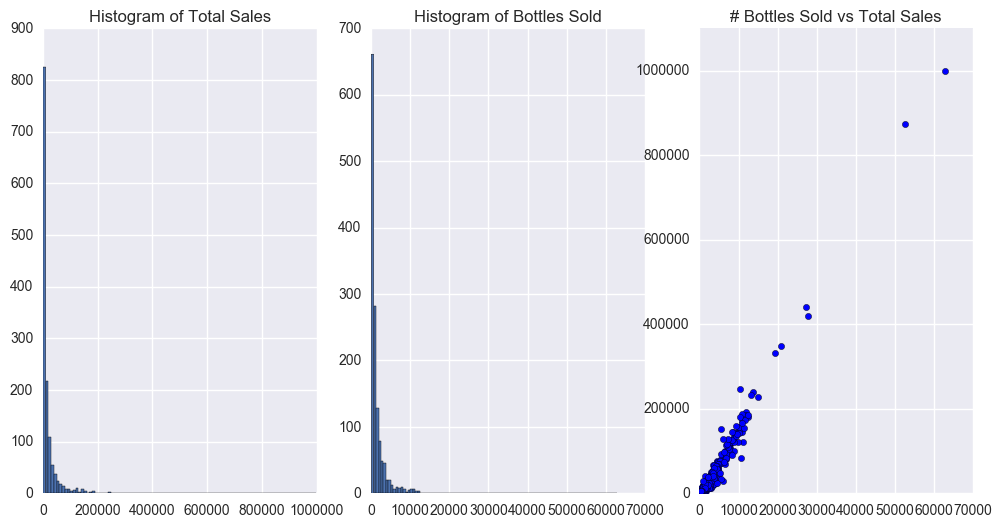

In [34]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,3,1)
ax1.hist(sales['total_sales'], bins = 100)
ax1.set_title("Histogram of Total Sales")
ax2 = fig.add_subplot(1,3,2)
ax2.hist(sales['total_bottles'], bins = 100)
ax2.set_title("Histogram of Bottles Sold")
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(sales['total_bottles'], sales['total_sales'])
ax3.set_title("# Bottles Sold vs Total Sales")
ax3.set_xlim(0,70000)
ax3.set_ylim(0,1100000)
plt.show()

In [35]:
sales['total_sales'].describe()

count      1372.000000
mean      20757.042259
std       50787.618666
min          39.020000
25%        3202.200000
50%        7226.150000
75%       19355.705000
max      997924.420000
Name: total_sales, dtype: float64

In [36]:
sales['total_bottles'].describe()

count     1372.000000
mean      1583.717201
std       3225.321436
min          1.000000
25%        312.000000
50%        665.500000
75%       1608.500000
max      62827.000000
Name: total_bottles, dtype: float64

Given the extreme right skew for both total sales and number of bottles, I will eliminate the the two outlying stores that sold over 30,000 bottles in a year.

In [37]:
# Remove two most extreme outliers from Polk County
sales = sales[sales['total_bottles'] < 30000]

In [38]:
county_pivot = sales.pivot_table(index = ['county'], values = ['total_sales'], aggfunc = np.mean)
county_pivot = county_pivot.sort_values('total_sales', ascending = False)
county_pivot.head(10)

,total_sales
county,
Johnson,32423.122830
Scott,31401.318462
Dallas,29456.824118
Cerro Gordo,28495.049000
Howard,27857.660000
Dickinson,27819.681429
Woodbury,26324.404211
Kossuth,26314.505714
Jones,26023.592500


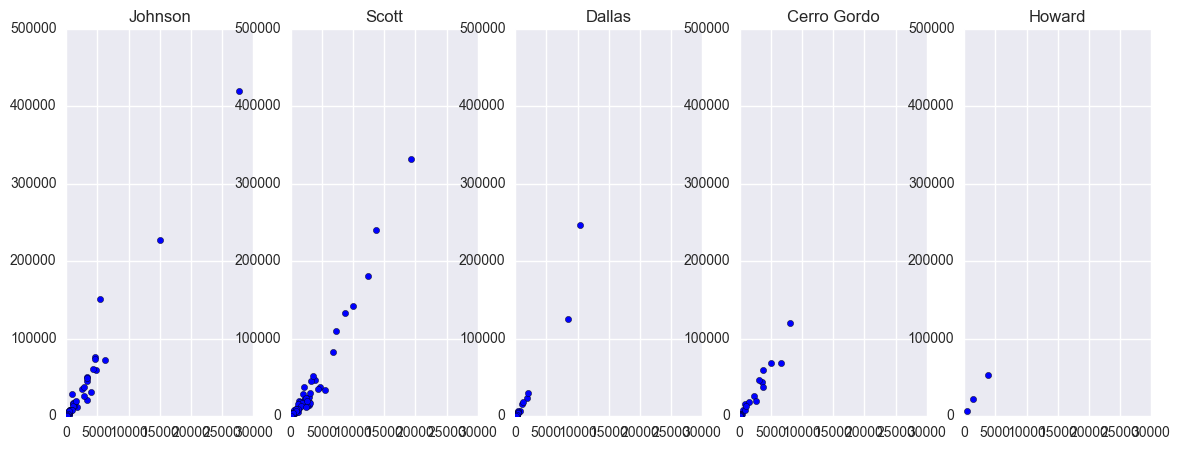

In [39]:
high_sale_counties = ['Johnson','Scott', 'Dallas','Cerro Gordo', 'Howard']
fig = plt.figure(figsize = (14,5))
n = 1
for i in high_sale_counties:
    ax = fig.add_subplot(1,5,n)
    n +=1
    mask = (sales['county']== i)
    ax.scatter(sales[mask]['total_bottles'], sales[mask]['total_sales'])
    ax.set_title(i)
    ax.set_ylim(0,500000)
    ax.set_xlim(0,30000)
plt.show()

In [40]:
# Look for correlations between # of stores in area and total average sales
sales.corr()

,total_sales,mean_sales,margin,total_bottles,mean_bottles,mean_ppb,total_liters,mean_liters,mean_ppl,stores_per_county,stores_per_city,stores_per_zip
total_sales,1.000000,0.252291,0.999995,0.976454,0.200997,0.297484,0.988715,0.349756,0.126936,0.080028,0.110614,0.165568
mean_sales,0.252291,1.000000,0.252501,0.198056,0.906910,0.235610,0.236028,0.922074,0.129487,-0.003878,-0.008826,0.069060
margin,0.999995,0.252501,1.000000,0.976406,0.201150,0.297517,0.988915,0.350342,0.126551,0.079800,0.110344,0.165389
total_bottles,0.976454,0.198056,0.976406,1.000000,0.189055,0.228083,0.972417,0.283639,0.130003,0.107248,0.168284,0.193570
mean_bottles,0.200997,0.906910,0.201150,0.189055,1.000000,0.004154,0.190225,0.875130,0.079237,0.014377,0.059516,0.105248
mean_ppb,0.297484,0.235610,0.297517,0.228083,0.004154,1.000000,0.278476,0.208188,0.523065,0.004774,-0.041993,-0.020655
total_liters,0.988715,0.236028,0.988915,0.972417,0.190225,0.278476,1.000000,0.357992,0.073221,0.063173,0.096576,0.155723
mean_liters,0.349756,0.922074,0.350342,0.283639,0.875130,0.208188,0.357992,1.000000,-0.034591,-0.042692,-0.043877,0.040112
mean_ppl,0.126936,0.129487,0.126551,0.130003,0.079237,0.523065,0.073221,-0.034591,1.000000,0.180935,0.225422,0.168533
stores_per_county,0.080028,-0.003878,0.079800,0.107248,0.014377,0.004774,0.063173,-0.042692,0.180935,1.000000,0.628172,0.385426


Total sales is most strongly correlated with the volume of liquor sold (either in bottles or liters), and there is a weak correlation with the price per bottle. However, the number of stores in each city or county does not seem to have a significant relationship with sales, so I won't include this parameter in the models.

## Making and Fitting Models
The goal is to construct linear regression models that capture the relationship between location of a store, its total bottle sales, its price per bottle, and its total sales. I'll start by looking at the relationship between total bottles sold and total sales.

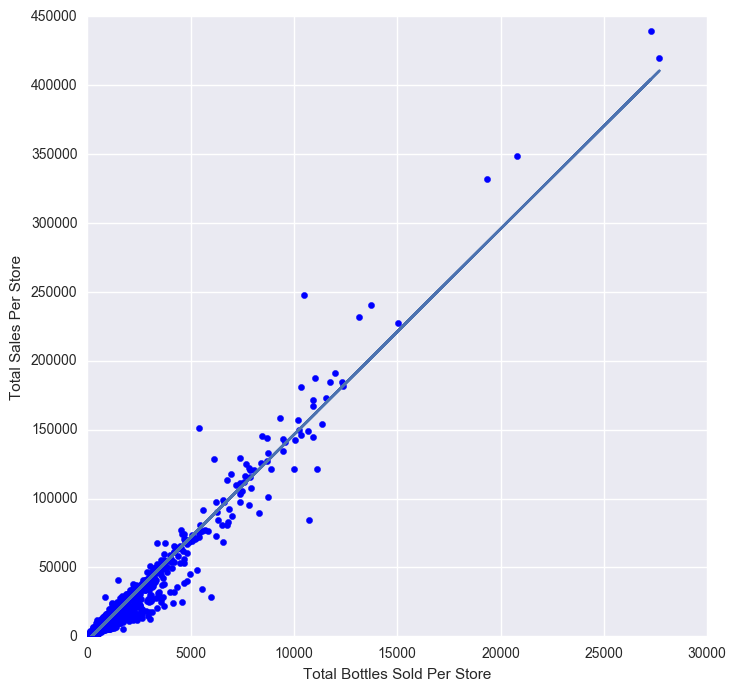

R_squared:  0.953462200558


In [41]:
# total sale ~ total bottles
X = (sales['total_bottles']).values.reshape(-1,1)
y = sales['total_sales']

lm1 = linear_model.LinearRegression(normalize = True)
model1 = lm1.fit(X,y)
pred_y = model1.predict(X)

plt.scatter(X,y, color = 'b', marker = 'o')
plt.plot(X,pred_y)
plt.xlim(0,30000)
plt.ylim(0,450000)
plt.xlabel("Total Bottles Sold Per Store")
plt.ylabel("Total Sales Per Store")
plt.show()
print "R_squared: ", sklearn.metrics.r2_score(y, pred_y)

The total number of bottles is a good predictor of total sales.

### Cross-validated Lasso Regression
Now, I'll include the county of each store as a catagorical variable, as well as the price per bottle at each store. I'll use 3-fold cross-validation to increase predictive power.

In [42]:
# make dummy variables for county
dummies = pd.get_dummies(sales["county"], prefix="county")
county_df = pd.concat([sales, dummies], axis=1)

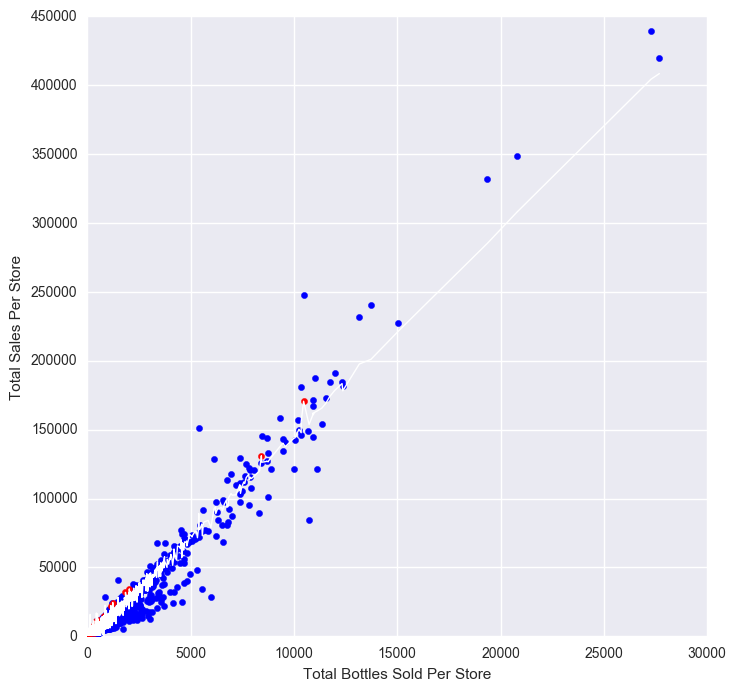

Alpha:  0.1
R-squared:  0.962005861656
MAE:  3842.92955834


In [43]:
# total sales ~ total bottles + county + price per bottle
county_df = county_df.sort_values('total_bottles')
X = county_df[['total_bottles','mean_ppb','county_Adair', 'county_Adams', 'county_Allamakee',
       'county_Appanoose', 'county_Audubon', 'county_Benton',
       'county_Black Hawk', 'county_Boone', 'county_Bremer',
       'county_Buchanan', 'county_Buena Vista', 'county_Butler',
       'county_Calhoun', 'county_Carroll', 'county_Cass', 'county_Cedar',
       'county_Cerro Gordo', 'county_Cherokee', 'county_Chickasaw',
       'county_Clarke', 'county_Clay', 'county_Clayton', 'county_Clinton',
       'county_Crawford', 'county_Dallas', 'county_Davis',
       'county_Decatur', 'county_Delaware', 'county_Des Moines',
       'county_Dickinson', 'county_Dubuque', 'county_Emmet',
       'county_Fayette', 'county_Floyd', 'county_Franklin',
       'county_Fremont', 'county_Greene', 'county_Grundy',
       'county_Guthrie', 'county_Hamilton', 'county_Hancock',
       'county_Hardin', 'county_Harrison', 'county_Henry', 'county_Howard',
       'county_Humboldt', 'county_Ida', 'county_Iowa', 'county_Jackson',
       'county_Jasper', 'county_Jefferson', 'county_Johnson',
       'county_Jones', 'county_Keokuk', 'county_Kossuth', 'county_Lee',
       'county_Linn', 'county_Louisa', 'county_Lucas', 'county_Lyon',
       'county_Madison', 'county_Mahaska', 'county_Marion',
       'county_Marshall', 'county_Mills', 'county_Mitchell',
       'county_Monona', 'county_Monroe', 'county_Montgomery',
       'county_Muscatine', "county_O'Brien", 'county_Osceola',
       'county_Page', 'county_Palo Alto', 'county_Plymouth',
       'county_Pocahontas', 'county_Polk', 'county_Pottawattamie',
       'county_Poweshiek', 'county_Ringgold', 'county_Sac', 'county_Scott',
       'county_Shelby', 'county_Sioux', 'county_Story', 'county_Tama',
       'county_Taylor', 'county_Union', 'county_Van Buren',
       'county_Wapello', 'county_Warren', 'county_Washington',
       'county_Wayne', 'county_Webster', 'county_Winnebago',
       'county_Winneshiek', 'county_Woodbury', 'county_Worth',
       'county_Wright']]
y = county_df['total_sales']

lm = linear_model.LassoCV(alphas = np.arange(0.1,10,0.1), normalize = True, cv = 3)
model = lm.fit(X,y)
predictions = model.predict(X)

my_counties = ['Dallas','Fremont']
mask = (county_df['county'].isin(my_counties))
X_mask = county_df[mask][['total_bottles','mean_ppb','county_Adair', 'county_Adams', 'county_Allamakee',
       'county_Appanoose', 'county_Audubon', 'county_Benton',
       'county_Black Hawk', 'county_Boone', 'county_Bremer',
       'county_Buchanan', 'county_Buena Vista', 'county_Butler',
       'county_Calhoun', 'county_Carroll', 'county_Cass', 'county_Cedar',
       'county_Cerro Gordo', 'county_Cherokee', 'county_Chickasaw',
       'county_Clarke', 'county_Clay', 'county_Clayton', 'county_Clinton',
       'county_Crawford', 'county_Dallas', 'county_Davis',
       'county_Decatur', 'county_Delaware', 'county_Des Moines',
       'county_Dickinson', 'county_Dubuque', 'county_Emmet',
       'county_Fayette', 'county_Floyd', 'county_Franklin',
       'county_Fremont', 'county_Greene', 'county_Grundy',
       'county_Guthrie', 'county_Hamilton', 'county_Hancock',
       'county_Hardin', 'county_Harrison', 'county_Henry', 'county_Howard',
       'county_Humboldt', 'county_Ida', 'county_Iowa', 'county_Jackson',
       'county_Jasper', 'county_Jefferson', 'county_Johnson',
       'county_Jones', 'county_Keokuk', 'county_Kossuth', 'county_Lee',
       'county_Linn', 'county_Louisa', 'county_Lucas', 'county_Lyon',
       'county_Madison', 'county_Mahaska', 'county_Marion',
       'county_Marshall', 'county_Mills', 'county_Mitchell',
       'county_Monona', 'county_Monroe', 'county_Montgomery',
       'county_Muscatine', "county_O'Brien", 'county_Osceola',
       'county_Page', 'county_Palo Alto', 'county_Plymouth',
       'county_Pocahontas', 'county_Polk', 'county_Pottawattamie',
       'county_Poweshiek', 'county_Ringgold', 'county_Sac', 'county_Scott',
       'county_Shelby', 'county_Sioux', 'county_Story', 'county_Tama',
       'county_Taylor', 'county_Union', 'county_Van Buren',
       'county_Wapello', 'county_Warren', 'county_Washington',
       'county_Wayne', 'county_Webster', 'county_Winnebago',
       'county_Winneshiek', 'county_Woodbury', 'county_Worth',
       'county_Wright']]
y_mask = county_df[mask]['total_sales']
predict_mask = model.predict(X_mask)

# Plot the fit
plt.scatter(X['total_bottles'], y, color = "b", marker = "o")
plt.plot(X['total_bottles'],predictions, linewidth = 1, color = "w")
plt.scatter(X_mask['total_bottles'],predict_mask, color = 'r')
plt.xlabel("Total Bottles Sold Per Store")
plt.ylabel("Total Sales Per Store")
plt.xlim(0,30000)
plt.ylim(0,450000)
plt.show()
print "Alpha: ", model.alpha_
print "R-squared: ", model.score(X,y)
print "MAE: ", sklearn.metrics.mean_absolute_error(y,predictions)

In [44]:
# Get coefficients
coef = model.coef_
var = []
coefs = []
for i in range(0,101):
    var.append(X.columns[i])
    coefs.append(coef[i])
model_summary = pd.DataFrame(columns = ['variable','coefficient'])
model_summary['variable'] =var
model_summary['coefficient'] = coefs
model_summary = model_summary.sort_values('coefficient', ascending = False)
model_summary.head()

,variable,coefficient
26,county_Dallas,6799.553635
37,county_Fremont,3052.469705
15,county_Carroll,2327.995402
14,county_Calhoun,2216.967505
13,county_Butler,1977.720222


According to the model, having a store in Dallas or Fremont counties is the best predictor of high sales. (Stores in those counties have higher sales than stores in other counties selling the same number of bottles.)

### Compare Model Predictions for Dallas County and Polk County

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


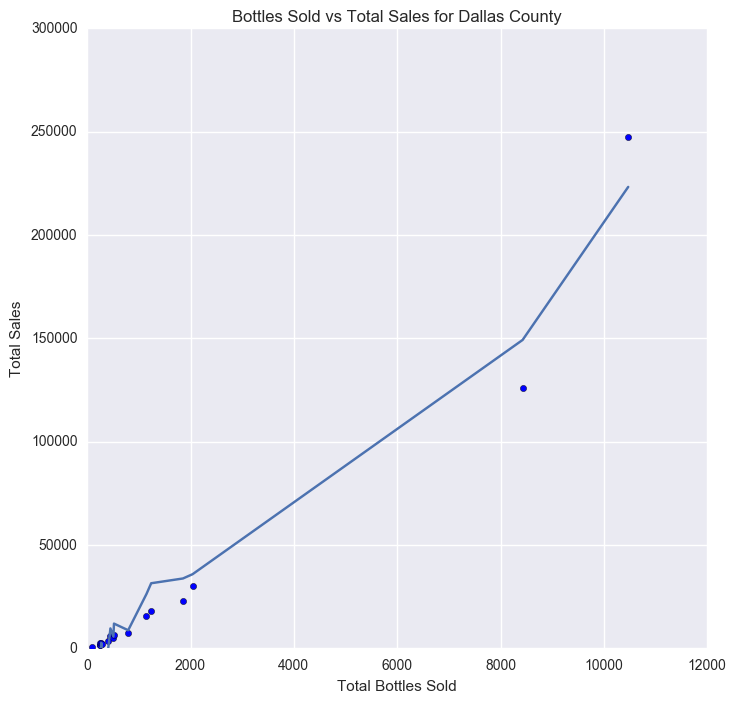

R-squared:  0.966167634188


In [45]:
mask = (sales['county']=='Dallas')
sales = sales.sort_values('total_bottles')
X = sales[mask][['total_bottles','mean_ppb']]
y = sales[mask]['total_sales']
lm = linear_model.LassoCV(normalize = True)
dallas_model = lm.fit(X,y)
predictions = dallas_model.predict(X)

plt.scatter(X['total_bottles'],y)
plt.plot(X['total_bottles'],predictions)
plt.xlabel("Total Bottles Sold")
plt.ylabel("Total Sales")
plt.title("Bottles Sold vs Total Sales for Dallas County")
plt.xlim(0,12000)
plt.ylim(0,300000)
plt.show()

print "R-squared: ", dallas_model.score(X,y)

In Dallas County, selling 6000 bottles in a year is predicted to yield over \$100,000 in total sales. Compare the predictions for Polk County, which had a lower average sales per store, though more stores overall:

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


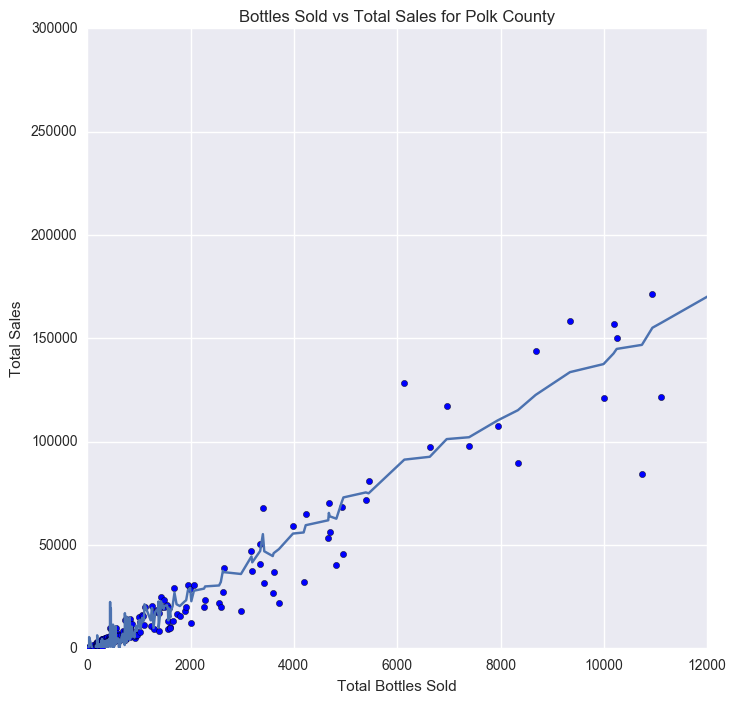

R-squared:  0.943191759741
[   14.0459037   1145.15412331]


In [46]:
mask = sales['county']=='Polk'
sales = sales.sort_values('total_bottles')
X = sales[mask][['total_bottles','mean_ppb']]
y = sales[mask]['total_sales']
lm = linear_model.LassoCV(normalize = True)
model = lm.fit(X,y)
predictions = model.predict(X)

plt.scatter(X['total_bottles'],y)
plt.plot(X['total_bottles'],predictions)
plt.xlabel("Total Bottles Sold")
plt.ylabel("Total Sales")
plt.title("Bottles Sold vs Total Sales for Polk County")
plt.xlim(0,12000)
plt.ylim(0,300000)
plt.show()

print "R-squared: ", model.score(X,y)
print model.coef_

In Polk County, selling 6,000 bottles yields closer to \$80,000 in total sales.

## Conclusions
After modeling the effects of county on liquor stores' total sales, I recommend that the liquor store owner open a new store in Dallas County. Excluding the extreme outliers in Polk County, stores in Dallas County are in the top five for mean sales, despite Dallas County ranking 10th in population. I will summarize the total sales for the stores with the highest total sales in 2015 in Dallas County, as well as the model's predictions for these stores' total sales in the future. The liquor store owner can use these predictions to estimate his potential total sales for the new store based on predicted bottle sales.

In [47]:
# Summarize the best performing stores in Dallas County
top_sellers = sales[sales['county']=='Dallas'].sort_values('total_sales', ascending = False)
top_sellers = top_sellers[['store_num','zip_code','county','city','total_sales','margin','total_bottles', 'mean_ppb']]

In [48]:
# Summarize the model's predictions for these stores in the future
X = top_sellers[['total_bottles','mean_ppb']]
y = top_sellers['total_sales']
predictions = dallas_model.predict(X)
top_sellers['Predicted Total Sales'] = predictions
top_sellers.head(10)

,store_num,zip_code,county,city,total_sales,margin,total_bottles,mean_ppb,Predicted Total Sales
323,3814,50266,Dallas,WEST DES MOINES,247417.42,83004.48,10472,26.315333,223268.666230
148,2665,50263,Dallas,WAUKEE,126114.56,42181.47,8428,15.550958,149223.054821
894,4678,50003,Dallas,ADEL,30260.71,10114.41,2040,12.985000,35866.922733
108,2612,50220,Dallas,PERRY,22949.94,7664.81,1854,13.235988,33803.651583
1288,5123,50325,Dallas,CLIVE,18253.13,6105.85,1239,15.253723,31494.184088
474,4137,50263,Dallas,WAUKEE,15861.67,5316.17,1148,14.275374,26301.515869
641,4384,50003,Dallas,ADEL,7306.21,2443.86,794,11.168800,8758.124125
660,4411,50069,Dallas,DE SOTO,6347.84,2128.80,519,13.188265,11969.751095
1062,4868,50263,Dallas,WAUKEE,5807.01,1939.58,450,12.871452,9647.059939
637,4378,50263,Dallas,WAUKEE,5089.54,1697.68,508,11.592195,5727.906964
